In [1]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, confusion_matrix, roc_auc_score

# A ) 
Here we will load the dataset, then split it into train, validation and test data. 
As the Credit Card data is biased, we also create a downzised dataset.

In [2]:
# Reading in credit card dataset.
x,y = ld.load_data(scaler='minmax')

# Splitting data in train and test data
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size=0.25, random_state= 0, shuffle=True, stratify=y)
# Splitting in train and validation
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain, test_size=0.25, random_state= 0, shuffle=True, stratify=ytrain)

# Extracting some useful shapes.
nx_train, ny_train = xtrain.shape
nx_test, ny_test = xtest.shape

In [26]:
# Extracting all datapoints where the output is 1 (i.e paying credit card dept).
indices = np.where(y == 1)
indices_zero = np.where(y == 0)
# Randomly extracting equal amount of datapoints where the output is 0 (i.e defaulting).
datapoints = np.random.choice(indices_zero[0], size=y[indices[0]].shape[0], replace=False)

#Stacking the two datasets
x_new = np.vstack((x[indices[0],:],x[datapoints,:]))
y_new = np.vstack((y[indices[0]],y[datapoints]))

# Renaming data
#xtrain = x_new
#ytrain = y_new

# Extracting some useful shapes.
nx_train, ny_train = xtrain.shape
nx_test, ny_test = xtest.shape


# B) 
Egen logistic regression med gradient descent.


In [108]:
eta = 0.1 # learning rate
doplot = True
doprint = False
Niteration = 250
beta = np.random.randn(x.shape[1],1)
costvec=[]
costvec_val=[]
loglvec=[]
xaxis=[]

%matplotlib qt
#plt.axis([0, Niteration, 0, 13])

start = time.time()
for iter in range(Niteration):
    
    sig = lrf.sigmoid(xtrain@beta)
    gradient = lrf.gradient_ols(xtrain,ytrain,sig)
    beta -= eta*gradient
    
    #Cost function
    cost = lrf.cost_log_ols(xtrain@beta,ytrain.T)
    cost_val = lrf.cost_log_ols(xval@beta,yval.T) # do this for testdata at the end. 
    #Log Loss function from sklearn
    logloss=log_loss(ytrain, np.round(xtrain@beta), eps=1e-16, normalize=True)
    if doprint:
        print('Cost', cost,'&','Log loss', logloss,'&','Cost test', cost_val)
    if doplot:
        costvec.append(cost.ravel())
        costvec_val.append(cost_val.ravel())
        loglvec.append(logloss)
        xaxis.append(iter+1)
        plt.plot(xaxis, costvec, 'b')
        plt.plot(xaxis, costvec_val, 'r')
        #plt.plot(xaxis, loglvec, 'g')
        plt.pause(1e-12)
plt.show()    
end = time.time()
print(end - start)
   
# et relevant plot er iterativt plot. 

18.107311010360718


In [110]:
# making confusion matrix to check observed data with model predictions. 

predictions = xtest@beta
sig_val = lrf.sigmoid(predictions)
sig_val = np.round(sig_val)

cm = confusion_matrix(ytest , sig_val.astype(int))
print(cm)

[[4272 1569]
 [ 773  886]]


# Accuracy. 
Både egen kode og tester med scikit. 

In [111]:

activation =lrf.sigmoid(xtrain@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytrain)/len(activation),'% Training Accuracy')
print(f1_score(ytrain, classes))

activation =lrf.sigmoid(xval@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==yval)/len(activation),'% Validation Accuracy')
print(f1_score(yval, classes))


activation =lrf.sigmoid(xtest@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytest)/len(activation),'% Test Accuracy')
print(f1_score(ytest, classes))



64.04460518384569 % Training Accuracy
0.6024658447184272
69.04888888888888 % Validation Accuracy
0.4349237260629666
68.77333333333333 % Test Accuracy
0.4307243558580457


# Egen logistisk regresjon med stokastisk gradient descent

In [112]:
eta = 0.1 # learning rate
doplot = True
doprint = False
Niteration = 250
batch_size = 3000
batch_size_held_out = nx_train-batch_size

beta = np.random.randn(x.shape[1],1)
costvec=[]
costvec_test=[]
loglvec=[]
xaxis=[]

%matplotlib qt
#plt.axis([0, Niteration, 0, 13])

indexes = np.arange(nx_train)


start = time.time()
for iter in range(Niteration):
    datapoints = np.random.choice(indexes, size=batch_size, replace=False)
    batch_x = xtrain[datapoints,:]
    batch_y = ytrain[datapoints]
    
    batch_x_held_out = np.delete(xtrain, datapoints, axis=0)
    batch_y_held_out = np.delete(ytrain, datapoints).reshape([batch_size_held_out,1])
    
    sig = lrf.sigmoid(batch_x@beta)
    gradient = lrf.gradient_ols(batch_x,batch_y,sig)
    beta -= eta*gradient
    
    #Cost function
    cost = lrf.cost_log_ols(batch_x@beta,batch_y.T)
    cost_test = lrf.cost_log_ols(batch_x_held_out@beta,batch_y_held_out.T)
    #Log Loss function from sklearn
    if doprint:
        logloss=log_loss(batch_y, np.round(batch_x@beta), eps=1e-16, normalize=True)
        print('Cost', cost,'&','Log loss', logloss,'&','Cost test', cost_test)
    if doplot:
        costvec.append(cost.ravel())
        costvec_test.append(cost_test.ravel())
        xaxis.append(iter+1)
        plt.plot(xaxis, costvec, 'b')
        plt.plot(xaxis, costvec_test, 'r')
        plt.pause(1e-12)
plt.show()

end = time.time()
print(end - start)
 

27.082622289657593


In [113]:
# making confusion matrix to check observed data with model predictions. 

predictions = xtest@beta
sig_val = lrf.sigmoid(predictions)
sig_val = np.round(sig_val)

cm = confusion_matrix(ytest , sig_val.astype(int))
print(cm)

[[4358 1483]
 [ 745  914]]


In [114]:
activation =lrf.sigmoid(xtrain@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytrain)/len(activation),'% Training Accuracy')
print(f1_score(ytrain, classes))

activation =lrf.sigmoid(xval@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==yval)/len(activation),'% Validation Accuracy')
print(f1_score(yval, classes))


activation =lrf.sigmoid(xtest@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytest)/len(activation),'% Test Accuracy')
print(f1_score(ytest, classes))


64.7302591922845 % Training Accuracy
0.6101440826184725
70.54222222222222 % Validation Accuracy
0.454395785314455
70.29333333333334 % Test Accuracy
0.4506903353057199


In [12]:

model = LogisticRegression()
model.fit(xtrain, ytrain)
predicted_classes = model.predict(xtrain)
accuracy = accuracy_score(ytrain.flatten(),predicted_classes)
accuracy = accuracy * 100
parameters = model.coef_
log_loss(ytrain, predicted_classes)

print(accuracy, '% Training Accuracy')

predicted_classes = model.predict(xtest)
accuracy = accuracy_score(ytest.flatten(),predicted_classes)
accuracy = accuracy * 100
parameters = model.coef_
log_loss(ytest, predicted_classes)

print(accuracy, '% Test Accuracy')

C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


71.26280892103676 % Training Accuracy
77.36 % Test Accuracy


# C) 
Neural Network. 

In [5]:

epochs=100
batch_size=100
n_features=x.shape[1]
etavec = np.logspace(-2, -1, 2)
lmbvec = np.logspace(-7, -6, 2)
lmbvec[0]=0

activation = [lrf.relu, lrf.relu, lrf.sigmoid, lrf.sigmoid]
derivative = [lrf.relu_deriv, lrf.relu_deriv, lrf.sigmoid_deriv, lrf.sigmoid_deriv]

saved_net = np.zeros((len(etavec), len(lmbvec)), dtype=object)
train_accuracy = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 10e-03,\
                            early_stop_nochange=1000, mode = 'classification')            
        neural_net.add_layers(n_features=[91,50,50,20], n_neurons = [50,50,20,1] , n_layers=4)
        
        neural_net.train(epochs, batch_size, x,y,activation,derivative ,x,y, verbose=True)

        pred = neural_net.feed_out(x, activation)
        train_accuracy[i,j] =  lrf.cost_log_ols(pred,y.T)
        print('training mse for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', train_accuracy [i,j])


Epoch 1 loss 0.8617617648525897
Epoch 2 loss 0.7947719361149052
Epoch 3 loss 0.7635307001991882
Epoch 4 loss 0.7501246337596155
Epoch 5 loss 0.7438512720557486
Epoch 6 loss 0.7400784974853983
Epoch 7 loss 0.7376594401157794
Epoch 8 loss 0.7361178221382266
Epoch 9 loss 0.7350696285741717


KeyboardInterrupt: 

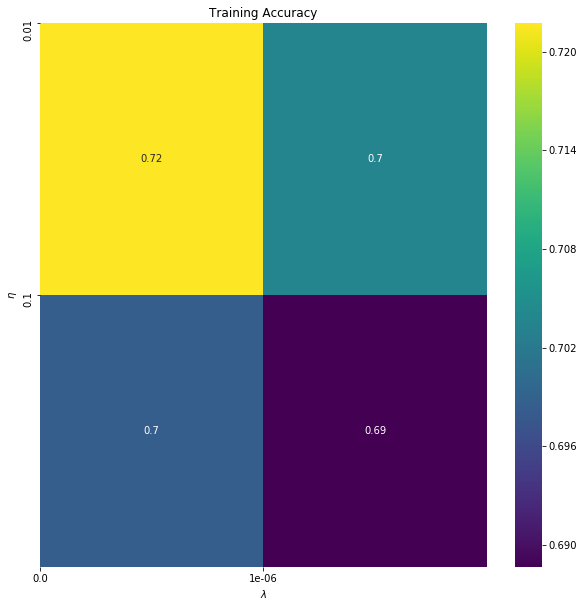

In [21]:
import seaborn as sns
train_accuracy[np.isnan(train_accuracy)]=2

yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_yticks(range(len(etavec)))
ax.set_xticks(range(len(lmbvec)))
plt.show()

In [22]:
best_eta_index, best_lmb_index = np.where(train_accuracy == np.min(train_accuracy))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 

In [ ]:
epochs=200
batch_size=2000

#neural_net = nn.ANN(lmb=best_lmb, bias=0.5, eta= best_eta, mode = 'classification')            
neural_net = nn.ANN(lmb=0, bias=0.5, eta= 0.1, mode = 'classification')            
neural_net.add_layers(n_features=[91,50,50,20], n_neurons = [50,50,20,1] , n_layers=4)
        
neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative ,x,y, verbose=True)


activ=neural_net.feed_out(xtrain, activation)
print(activ)

classes=np.round(activ)
print(classes)

print(100*np.sum(classes==y)/len(activ),'% Training Accuracy')
#print(f1_score(ytrain, classes)) 

cm = confusion_matrix(y , classes)
print(cm)

Epoch 1 loss 0.8037606926229055
Epoch 2 loss 0.777542033404866
Epoch 3 loss 0.7633203848770056
Epoch 4 loss 0.757584347072726
Epoch 5 loss 0.7533902006240558
Epoch 6 loss 0.7504879768767121
Epoch 7 loss 0.7484983173163314
Epoch 8 loss 0.7470041752410391
Epoch 9 loss 0.7457833905878819
Epoch 10 loss 0.7447483115668843
Epoch 11 loss 0.7439401867810663
Epoch 12 loss 0.743212638266596
Epoch 13 loss 0.7422262135843666
Epoch 14 loss 0.7416549833522816
Epoch 15 loss 0.7410022912012096
Epoch 16 loss 0.7403438957191466
Epoch 17 loss 0.7399900233661802
Epoch 18 loss 0.7397635996204106
Epoch 19 loss 0.7394637653618772
Epoch 20 loss 0.7394499698625359
Epoch 21 loss 0.7392836807670093
Epoch 22 loss 0.7390674280599924
Epoch 23 loss 0.7388633323101734
Epoch 24 loss 0.7389774827584955
Epoch 25 loss 0.7390497198471682
Epoch 26 loss 0.7389328365362247
Epoch 27 loss 0.7387329637569635
Epoch 28 loss 0.7389012168656522
Epoch 29 loss 0.7387791676857328
Epoch 30 loss 0.7389176201406132
Epoch 31 loss 0.738918

In [7]:
activ=neural_net.feed_out(xtest, activation)
print(activ)

classes=np.round(activ)
print(classes)

print(100*np.sum(classes==ytest)/len(activ),'% Test Accuracy')
#print(f1_score(ytrain, classes)) 

cm = confusion_matrix(ytest , classes)
print(cm)

[[0.18402295]
 [0.1649728 ]
 [0.10419689]
 ...
 [0.0709969 ]
 [0.10858862]
 [0.10726528]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
77.8 % Test Accuracy
[[5596  245]
 [1420  239]]


In [8]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(hidden_layer_sizes=(50,50,20,), max_iter=200, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mlp.fit(x, y.ravel())
print("Training set score: %f" % mlp.score(x, y))
print("Test set score: %f" % mlp.score(xtest, ytest))



Iteration 1, loss = 0.45853404
Iteration 2, loss = 0.43899701
Iteration 3, loss = 0.43599654
Iteration 4, loss = 0.43445331
Iteration 5, loss = 0.43379356
Iteration 6, loss = 0.43299177
Iteration 7, loss = 0.43188410
Iteration 8, loss = 0.43080295
Iteration 9, loss = 0.42995817
Iteration 10, loss = 0.43015005
Iteration 11, loss = 0.42927207
Iteration 12, loss = 0.42971320
Iteration 13, loss = 0.42882539
Iteration 14, loss = 0.42783601
Iteration 15, loss = 0.42752122
Iteration 16, loss = 0.42741703
Iteration 17, loss = 0.42559174
Iteration 18, loss = 0.42591886
Iteration 19, loss = 0.42562438
Iteration 20, loss = 0.42484653
Iteration 21, loss = 0.42480954
Iteration 22, loss = 0.42423952
Iteration 23, loss = 0.42390833
Iteration 24, loss = 0.42330049
Iteration 25, loss = 0.42262858
Iteration 26, loss = 0.42205773
Iteration 27, loss = 0.42145079
Iteration 28, loss = 0.42052165
Iteration 29, loss = 0.42082193
Iteration 30, loss = 0.42008572
Iteration 31, loss = 0.41872701
Iteration 32, los

C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [10]:
pred = mlp.predict(xtest)
accuracy = accuracy_score(ytest.flatten(),pred)
accuracy = accuracy * 100
print(accuracy)

cm = confusion_matrix(ytest , pred)
print(cm)

85.93333333333332
[[5671  170]
 [ 885  774]]


In [11]:
pred = mlp.predict(xtest)
accuracy = accuracy_score(ytest.flatten(),pred)
accuracy = accuracy * 100
print(accuracy)

cm = confusion_matrix(ytest , pred)
print(cm)

85.93333333333332
[[5671  170]
 [ 885  774]]
